# (b) (1.5 point) Finding the most informative features for depression. 
Explore a filter feature selection method of your choice to identify the n features that are the most informative of depression on the training data. Report and discuss the 20 features that are most indicative of depression. Use the same machine learning algorithm as in question (a.i) to classify between depression and no depression based on n number of selected features, where n = 10, 20, 30, . . . , 50.
Plot the simple and balanced depression classification accuracy (for all participants, as well as female and male participants separately) and EO on the test set against the number n ofselected features. Please discuss the results.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import sklearn
from sklearn import model_selection, preprocessing, metrics
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest
from sklearn import decomposition
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier


In [2]:
wd = '/kaggle/input/woz-speech/'
#Set training and test folder paths
training_path = wd+'features_train/features_train'
test_path = wd+'features_test/features_test'

#Load labels file
labels = pd.read_csv(wd+'labels.csv')

#Load feature description files, take out column 0 to use as header for training/test sets
features = pd.read_csv(wd+'feature_description.csv', encoding_errors='ignore', header=None, index_col=0)
features = features.index.tolist()
features

def load_data(folder_path):
    #Init empty dataframe
    res = pd.DataFrame()
    for file in os.listdir(folder_path):
        #for each speaker file
        if file.endswith('.csv'):
            #get participant id from filename, eg filename: 'spk_305.csv'
            participant = float(file.split('_')[1].split('.')[0])
            #find labels for the participant
            label = labels[labels['Participant_ID'] == participant]
            #load participant feature file
            file_path = os.path.join(folder_path, file)
            data_df = pd.read_csv(file_path, header=None, names=features)
            #Add labels and participant id columns
            data_df['participant'] = participant
            data_df['gender'] = label['Gender'].values[0]
            data_df['depression'] = label['Depression'].values[0]
            #combine everything to result
            res = pd.concat([res, data_df])
    return res

#Load training data
training_df = load_data(training_path)
test_df = load_data(test_path)

def preprocess_data(data):
    #drop missing va;ues since there is just 1 sample
    data_nona = data.dropna()
    #Normalization z-score
    scaler = StandardScaler()    
    # Store the columns to keep for later concatenation
    columns_to_keep = ['participant', 'gender', 'depression']
    # Extract the columns to be scaled and drop them from the original DataFrame
    temp = data_nona[columns_to_keep].copy()
    data_nona.drop(columns=columns_to_keep, axis=1, inplace=True)
    # Scale the remaining columns using StandardScaler and convert back to DataFrame
    scaled_data = pd.DataFrame(scaler.fit_transform(data_nona), columns=data_nona.columns)
    scaled_data.reset_index(drop=True, inplace=True)
    temp.reset_index(drop=True, inplace=True)
    # Concatenate the scaled data with the columns we kept earlier
    processed_data = pd.concat([scaled_data, temp], axis=1)
    return processed_data

# Calculates accuracy
# pass true and predicted labels
# return accuracy score
def calculate_total_accuracy(true_labels, predicted_labels):
    return accuracy_score(true_labels, predicted_labels)

# Calculates accuracy
# pass true and predicted labels
# return balanced accuracy score
def calculate_balanced_accuracy(true_labels, predicted_labels):
    #calculkate confusion matrix
    matrix = confusion_matrix(true_labels, predicted_labels)
    TP = matrix[1, 1]
    TN = matrix[0, 0]
    FP = matrix[0, 1]
    FN = matrix[1, 0]
    #For positive class, how many correct predictions
    accuracy_positive = TP/(TP+FN)
    #For negative class how many 
    accuracy_negative = TN/(TN+FP)
    return 0.5*(accuracy_positive + accuracy_negative)

#Calculates Equality of Opportunity
# pass true and predicted labels for male samples
# pass true and predicted labels for female samples
# return balanced accuracy score
def calculate_EO(true_labels_male, 
                 true_labels_female,
                 predicted_labels_male,
                predicted_labels_female):
    #Calculate True pistive rate for male gender with confusion matrix
    matrix_male = confusion_matrix(true_labels_male, predicted_labels_male)
    TP = matrix_male[1, 1]
    TN = matrix_male[0, 0]
    FN = matrix_male[1, 0]
    TPR_male = TP/(TP+FN)

    #Calculate True pistive rate for female gender with confusion matrix
    matrix_female = confusion_matrix(true_labels_female, predicted_labels_female)
    TP = matrix_female[1, 1]
    TN = matrix_female[0, 0]
    FN = matrix_female[1, 0]
    TPR_female = TP/(TP+FN)
    
    # Calculate EO
    return 1-abs(TPR_male-TPR_female) 

#Function to calculate majority votings
#Pass labels
#Returns mode or which label was predicted most
def majority_voting(df):
    counts = df.value_counts()
    return counts.idxmax()

#Function to calculate all metrics
#Pass true labels, predicted labels and a reference(test/val) dataframe
#referece dataframe should have all labels and features
#Returns a dictionary with all the metric calculated
def calculate_metrics(y_true, y_pred, test_data, EO=True):
    # Initialize metrics
    metrics = {}
    #---------------------------------------------------CALCULATING TOTAL METRICS
    #calculate total accuracy
    metrics["Total accuracy"] = calculate_total_accuracy(y_true, y_pred)
    #calculate total balanced accuracy
    metrics["Total Balanced accuracy"] = calculate_balanced_accuracy(y_true, y_pred)
    #calculate total EO
    if(EO):
        #find gender based indices for true labels from data
        male_indices = test_data[test_data['gender']==1].index
        female_indices = test_data[test_data['gender']==0].index
        #separate true labels based on indices
        male_true = y_true.loc[male_indices]
        female_true = y_true.loc[female_indices]
        #Find the corresponding indices for predicted labels from true_labels
        male_true_index_list = male_true.index.tolist()
        female_true_index_list = female_true.index.tolist()
        #Get separated predicted labels based on gender
        male_predicted = y_pred[[male_true_index_list.index(index) for index in male_true_index_list]]
        female_predicted = y_pred[[female_true_index_list.index(index) for index in female_true_index_list]]
        metrics["Total EO"] = calculate_EO(male_true, female_true, male_predicted, female_predicted)
    #-------------------------------------------------CALCULATING AGGREGATED METRICS FOR EACH PARTICIPANT
    predictions_df = pd.DataFrame({'participant': test_data['participant'], 'predicted_label': y_pred, 'true_label': y_true})
    aggregated_y_true = predictions_df.groupby('participant')['true_label'].agg(majority_voting)
    aggregated_y_pred = predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
    #Calculate aggregated accuracy score
    metrics["Aggregated accuracy score"] = calculate_total_accuracy(aggregated_y_true, aggregated_y_pred)
    #Calculate balanced aggregated accuracy
    metrics["Aggregated balanced accuracy score"] = calculate_balanced_accuracy(aggregated_y_true, aggregated_y_pred)
    if(EO):
        #Calculate aggregated EOs
        male_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[male_indices], 'predicted_label': y_pred, 'true_label': y_true})
        male_aggregated_y_true = male_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
        male_aggregated_y_pred = male_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
        female_predictions_df = pd.DataFrame({'participant': test_data['participant'].loc[female_indices], 'predicted_label': y_pred, 'true_label': y_true})
        female_aggregated_y_true = female_predictions_df.groupby('participant')['true_label'].agg(majority_voting)
        female_aggregated_y_pred = female_predictions_df.groupby('participant')['predicted_label'].agg(majority_voting)
        metrics["Aggregated EO score"] = calculate_EO(male_aggregated_y_true, female_aggregated_y_true, male_aggregated_y_pred, female_aggregated_y_pred)
    
    return metrics

In [60]:
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

#Choosing the most infomative components for depression based on F value
best = SelectKBest(k=20).fit(X, y)
dep_idxs = best.get_support(indices=True)
print('Most predictive features:', list(X.columns[dep_idxs]))

Most predictive features: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'loudness_sma3_amean', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'mfcc3_sma3_amean', 'HNRdBACF_sma3nz_amean', 'F1frequency_sma3nz_amean', 'spectralFluxV_sma3nz_amean', 'spectralFluxV_sma3nz_stddevNorm', 'equivalentSoundLevel_dBp']


In [13]:
#------------------------------Trying different numbers of features-------------------------------------------------------

warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']

# Define the depths to experiment with
num_features = range(10, 60, 10)
# Initialize metrics
metrics = {}

# Perform cross-validation for each tree depth
for n in num_features:
    #Find n best features for depression
    best = SelectKBest(k=n).fit(X, y)
    idxs = best.get_support(indices=True)
    X_new = X.iloc[:, idxs]
    # Initialize decision tree model
    tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    #list to store metrics for each cross validation split
    fold_metrics = []

    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X):
        X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #Fit the training set
        tree.fit(X_train, y_train)
        #Predict validation set
        y_pred = tree.predict(X_val)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

    #find avg metrics for each number of features
    metrics[n] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[n] = sums

#Print metrics for all the hyperparameters (number of features)
for n in metrics:
    print(f"for {n} features: ")
    print(metrics[n]['Aggregated balanced accuracy score'])
    print()
    

for 10 features: 
0.7097222222222221

for 20 features: 
0.7363095238095237

for 30 features: 
0.8134920634920635

for 40 features: 
0.7753968253968254

for 50 features: 
0.8285714285714286



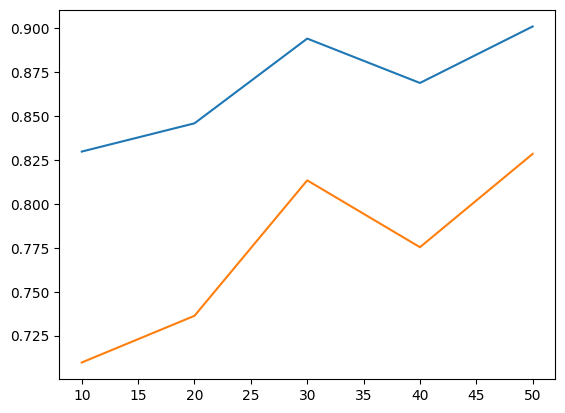

In [14]:
acc = []
bac = []
for n in metrics:
    acc.append(metrics[n]['Aggregated accuracy score'])
    bac.append(metrics[n]['Aggregated balanced accuracy score'])
plt.plot(metrics.keys(), acc)
plt.plot(metrics.keys(), bac)

50 features seems to be ideal.

In [15]:
test_data = preprocess_data(test_df)
training_data = preprocess_data(training_df)
X_train = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_train = training_data['depression']
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['depression']
num_features = 50

#Find n best features for depression
best = SelectKBest(k=num_features).fit(X_train, y_train)
idxs = best.get_support(indices=True)
X_new = X_train.iloc[:, idxs]
X_test_new = X_test.iloc[:, idxs]
# Initialize decision tree model
tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')
# Cross validation k fold, 4:1::training:validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
#list to store metrics for each cross validation split
fold_metrics = []

# Perform cross-validation and collect metrics
for train_index, val_index in kf.split(X_train):
    X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    #Fit the training set
    tree.fit(X_train, y_train)
    #Predict validation set
    y_pred = tree.predict(X_val)
    #calculate metrics
    fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index]))

y_pred = tree.predict(X_test.iloc[:, idxs])
#get metrics
calculate_metrics(y_test, y_pred, test_data)

{'Total accuracy': 0.7067073170731707,
 'Total Balanced accuracy': 0.5660000862577093,
 'Total EO': 0.918246611895232,
 'Aggregated accuracy score': 0.75,
 'Aggregated balanced accuracy score': 0.5833333333333334,
 'Aggregated EO score': 0.8}

The aggregated balanced accuracy score is 0.583, the aggregated accuracy score is 0.75, and the E0 score is 0.8 using only the 50 most informative features from the dataset.

# (c) (1.5 point) Finding the most informative features for gender. 
Explore a filter feature selection method of your choice to identify the m features that are the most informative of gender on the training data. Report and discuss the 20 features that are most indicative of gender. What do you observe in relation to question (b)? Use the same machine learning algorithm as in question (a.ii) to classify between female and male speakers based on the m number of selected features, where m = 5, 10, 15, . . . , 30. Plot the simple and balanced gender classification accuracy against the number m of selected features on the test data. Please discuss the results.

In [63]:
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['gender']

#Choosing the most infomative components for depression based on F value
best = SelectKBest(k=20).fit(X, y)
gen_idxs = best.get_support(indices=True)
print('Most predictive features for gender:', list(X.columns[gen_idxs]))
print('')
print('Most predictive features for depression:', list(X.columns[dep_idxs]))
print('')

matches = 0
for f in list(X.columns[gen_idxs]):
    if f in X.columns[dep_idxs]:
        matches += 1
        
overlap = (matches/20)*100
print(f'{overlap}% of the features that are most predictive of gender are also among the most predictive of depression.')

Most predictive features for gender: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'mfcc3_sma3_amean', 'mfcc4_sma3_amean', 'jitterLocal_sma3nz_stddevNorm', 'shimmerLocaldB_sma3nz_stddevNorm', 'HNRdBACF_sma3nz_amean', 'F1frequency_sma3nz_amean', 'F1frequency_sma3nz_stddevNorm', 'F2frequency_sma3nz_stddevNorm', 'F3frequency_sma3nz_stddevNorm', 'F3bandwidth_sma3nz_stddevNorm', 'hammarbergIndexV_sma3nz_stddevNorm', 'slopeV0-500_sma3nz_amean', 'spectralFluxV_sma3nz_stddevNorm', 'mfcc3V_sma3nz_amean', 'mfcc4V_sma3nz_amean', 'slopeUV0-500_sma3nz_amean']

Most predictive features for depression: ['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'loudness_sma3_amean', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sm

Additionally, the 4 most predictive features are the same.

In [37]:
#------------------------------Trying different numbers of features-------------------------------------------------------

warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['gender']

# Define the depths to experiment with
num_features = range(5, 35, 5)
# Initialize metrics
metrics = {}

for n in num_features:
    best = SelectKBest(k=n).fit(X, y)
    idxs = best.get_support(indices=True)
    X_new = X.iloc[:, idxs]
    # Initialize Logistic regression model
    model = Perceptron(penalty=None)
    # Cross validation k fold, 4:1::training:validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    #list to store metrics for each cross validation split
    fold_metrics = []
    
    # Perform cross-validation and collect metrics
    for train_index, val_index in kf.split(X_new):
        X_train, X_val = X_new.iloc[train_index], X_new.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
        #Fit the training set
        model.fit(X_train, y_train)
        #Predict validation set
        y_pred = model.predict(X_val)
        #calculate metrics
        fold_metrics.append(calculate_metrics(y_val, y_pred, training_data.iloc[val_index], False))
    
    #find avg metrics for each number of features
    metrics[n] = {}
    sums = {}
    for metric in fold_metrics:
        for key, value in metric.items():
            sums[key] = sums.get(key, 0) + value
    for key in sums:
        sums[key]/=len(fold_metrics)
    metrics[n] = sums

#Print metrics for all the hyperparameters (number of features)
for n in metrics:
    print(f"for {n} features: ")
    print(metrics[n]['Aggregated balanced accuracy score'])
    print()
    

for 5 features: 
0.9539215686274509

for 10 features: 
0.8312091503267973

for 15 features: 
0.9065359477124183

for 20 features: 
0.9395424836601307

for 25 features: 
0.9473856209150326

for 30 features: 
0.9282679738562092



The best number of features is 5.

In [55]:
test_data = preprocess_data(test_df)
training_data = preprocess_data(training_df)
X_train = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_train = training_data['gender']
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['gender']

# Find the 5 best features
best = SelectKBest(k=5).fit(X, y)
idxs = best.get_support(indices=True)
X_new = X_train.iloc[:, idxs]
X_test = X_test.iloc[:, idxs]
# Initialize Perceptron
model = Perceptron(penalty=None)

#Fit the training set
model.fit(X_new, y_train)
#Predict validation set
y_pred = model.predict(X_test)
#calculate metrics
calculate_metrics(y_test, y_pred, test_data, False)


{'Total accuracy': 0.8560975609756097,
 'Total Balanced accuracy': 0.8501407866860898,
 'Aggregated accuracy score': 0.9,
 'Aggregated balanced accuracy score': 0.875}

The aggregated accuracy score is 0.9 and the aggregated balanced accuracy score is 0.875

# (d) (2 points) Mitigating bias via removing gender-dependent features. 
Remove the m most informative features of gender from the original feature set. Using the revised feature set, use the same machine learning algorithm as in (a.i) to conduct depression classification. Please report the results similar to (a.i) and discuss your findings.

In [56]:
warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X = training_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y = training_data['depression']
g = training_data['gender']
test_data = preprocess_data(test_df)
X_test = test_data.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_test = test_data['depression']


#Find the 5 most predictive features for gender
best = SelectKBest(k=5).fit(X, g)
idxs = best.get_support(indices=True)
#Remove those features
X = X.iloc[:, ~idxs]
X_test = X_test.iloc[:, ~idxs]

# Initialize decision tree model
tree = DecisionTreeClassifier(max_depth=70, criterion='entropy')

#Fit the training set
tree.fit(X, y)

y_pred = tree.predict(X_test)
#get metrics
calculate_metrics(y_test, y_pred, test_data)


{'Total accuracy': 0.5862804878048781,
 'Total Balanced accuracy': 0.48262482209347457,
 'Total EO': 0.8992697142054631,
 'Aggregated accuracy score': 0.55,
 'Aggregated balanced accuracy score': 0.39285714285714285,
 'Aggregated EO score': 1.0}

This somehow made it suck so much more, but the E0 score is good I guess? It makes sense that performance got worse though since the features that were most predictive of gender were also most useful for the depression model.

# Part e, attempting to mitigate the effects of gender.
Here, I have tried creating two separate classifiers to predict depression, one for females and one for males. 

In [85]:
warnings.filterwarnings("ignore")
training_data = preprocess_data(training_df)
X_f = training_data.loc[training_data['gender'] == 0, :]
X_m = training_data.loc[training_data['gender'] == 1, :]
training_data = pd.concat((X_f, X_m))
X_f = X_f.drop(columns = ['participant', 'gender', 'depression'], axis=1)
X_m = X_m.drop(columns = ['participant', 'gender', 'depression'], axis=1)
y_f = training_data['depression'].loc[training_data['gender'] == 0]
y_m = training_data['depression'].loc[training_data['gender'] == 1]


test_data = preprocess_data(test_df)

X_test_f = test_data.loc[test_data['gender'] == 0,:]
X_test_m = test_data.loc[test_data['gender'] == 1,:]

X_test_f = X_test_f.drop(columns = ['participant','gender', 'depression'], axis=1)
X_test_m = X_test_m.drop(columns = ['participant','gender', 'depression'], axis=1)
y_test_f = test_data['depression'].loc[test_data['gender'] == 0]
y_test_m = test_data['depression'].loc[test_data['gender'] == 1]

#Create the model for females
tree_f = DecisionTreeClassifier(max_depth=70, criterion='entropy')

#Fit the training set
tree_f.fit(X_f, y_f)

y_pred = tree_f.predict(X_test_f)
#get metrics
print('For females:', calculate_metrics(y_test_f, y_pred, test_data.loc[test_data['gender'] == 0,:], False))

#Create the model for males
tree_m = DecisionTreeClassifier(max_depth=70, criterion='entropy')

#Fit the training set
tree_m.fit(X_m, y_m)

y_pred = tree_m.predict(X_test_m)
#get metrics
print('For males:', calculate_metrics(y_test_m, y_pred, test_data.loc[test_data['gender'] == 1,:], False))


For females: {'Total accuracy': 0.5961995249406176, 'Total Balanced accuracy': 0.5706442334033421, 'Aggregated accuracy score': 0.375, 'Aggregated balanced accuracy score': 0.5}
For males: {'Total accuracy': 0.7793753098661378, 'Total Balanced accuracy': 0.6540854502986833, 'Aggregated accuracy score': 1.0, 'Aggregated balanced accuracy score': 1.0}


These results suggests that the decision tree model is working extremely well for the males in the test set but horribly for females. This suggests that an entirely different type of model may be needed to predict depression in females. 